# The following dataset is used: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction). The objective is to build a model using one of the Naive Bayes variants to predict if a person has heart disease.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import warnings
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from scipy import stats
from sklearn import metrics

warnings.filterwarnings("ignore")

file = "https://raw.githubusercontent.com/Mafasamo/PortafolioML/refs/heads/main/Naive%20Bayes/heart.csv"

raw_data = pd.read_csv(file)
raw_data.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Naive Bayes models are based on Bayes' theorem, which states the following:
$P(A|B) = \frac{P(B|A)*P(A)}{P(B)}$, where:
  *   $P(A∣B)$ is the probability that event $A$ occurs given that evidence $B$ has been observed.
  *   $P(B∣A)$ is the probability of observing evidence $B$ given that event $A$ has occurred.
  *   $P(A)$ and $P(B)$ are the marginal probabilities of events $A$ and $B$ occurring, respectively.

The term Naive refers to the assumption that the predictor variables are independent of each other.


## Preprocessing:

The total number of null values is checked, and the information for the training set is displayed.

In [ ]:
total_nulls = raw_data.isnull().sum().sum()
print("Total number of null values in the DataFrame:", total_nulls)

target = raw_data[['HeartDisease']].copy()
raw_data = raw_data.drop(["HeartDisease"], axis=1)
columns = raw_data.columns

X_train, X_test, y_train, y_test = train_test_split(raw_data, target, test_size=0.2, random_state=42, shuffle=True)
X_train.info()

Total number of null values in the DataFrame: 0
<class 'pandas.core.frame.DataFrame'>
Index: 734 entries, 795 to 102
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 68.8+ KB


Categorical columns in the training dataset are identified, and OneHotEncoding is used to convert them into binary variables. Next, the original categorical columns in the training and test sets are replaced with their encoded versions.

In [ ]:
# Identify categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the categorical columns
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_columns])

encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_columns)

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# Drop the original categorical columns from X_train and X_test
X_train = X_train.drop(columns=categorical_columns)
X_test = X_test.drop(columns=categorical_columns)

X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)
columns = X_train.columns
X_train.head()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
795,42,120,240,1,194,0.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
25,36,130,209,0,178,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
84,56,150,213,1,125,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
10,37,130,211,0,142,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
344,51,120,0,1,104,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


There are several variants of Naive Bayes, including:

*   Gaussian Naive Bayes: Assumes that the variables follow a Gaussian (normal) distribution.
*   Multinomial Naive Bayes: Suitable for classification with discrete variables.
*   Bernoulli Naive Bayes: Similar to Multinomial Naive Bayes but assumes binary variables.
*   Complement Naive Bayes: A modification of Multinomial Naive Bayes that is particularly effective for imbalanced datasets.
*   Categorical Naive Bayes: Suitable for categorical variables with more than two levels.

The Shapiro-Wilk normality test is conducted for each feature in X_train. This test evaluates whether the data for each feature follows a normal distribution. For each column, the test statistic (stat) and p-value (p) are calculated. The p-value helps determine if we can reject the null hypothesis that the data follows a normal distribution.

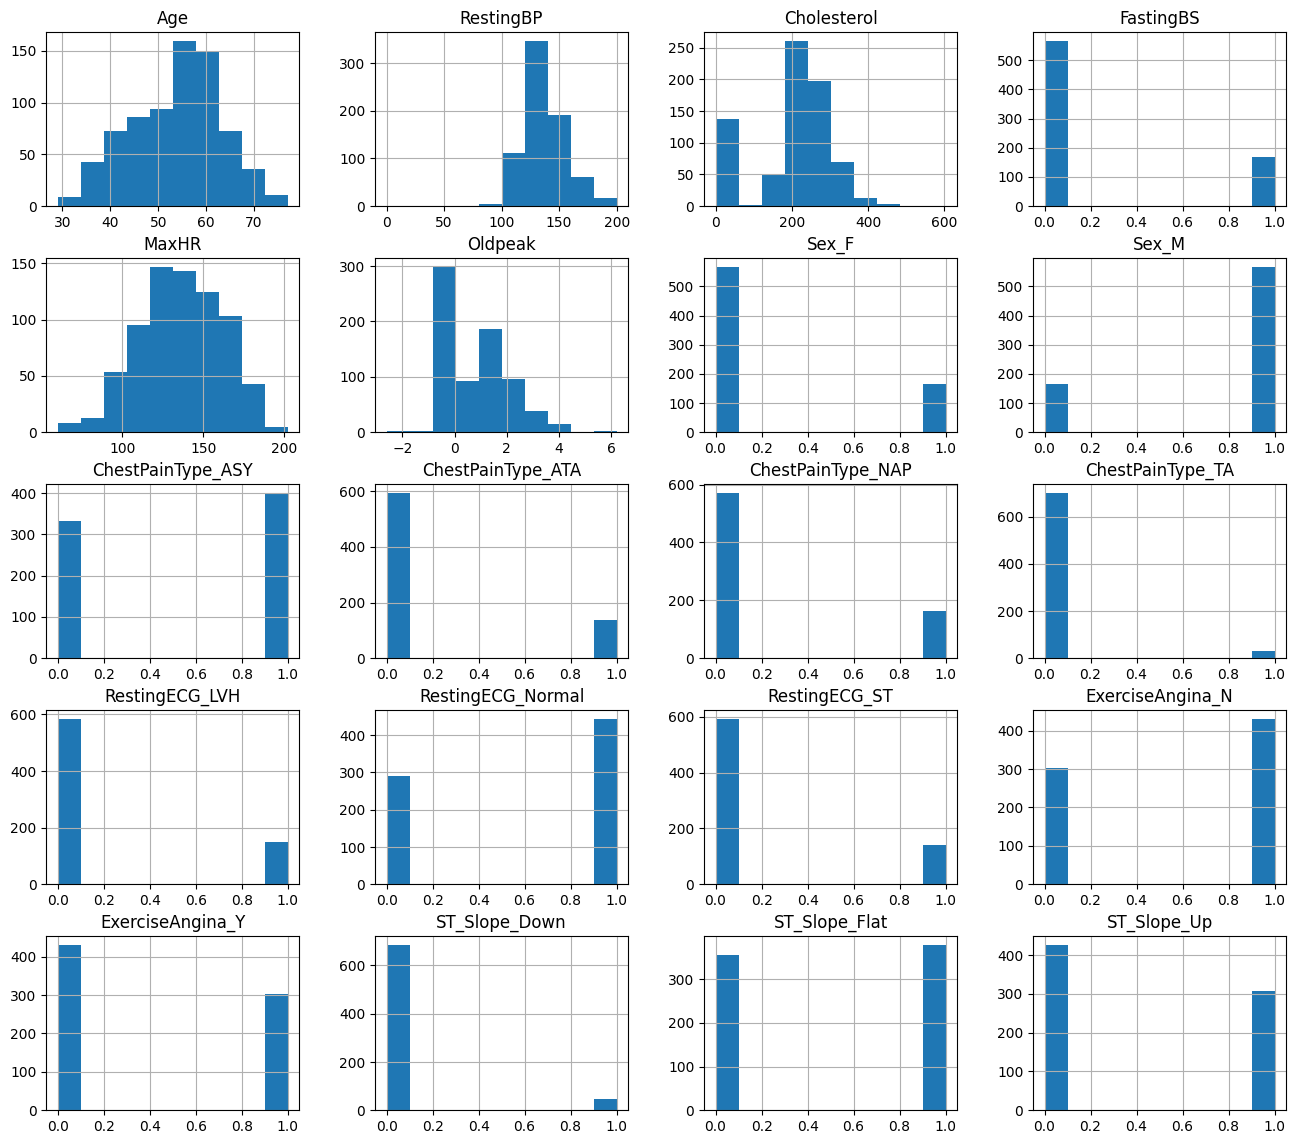

Attribute: Age, p-value: 0.00022957579023653827
Attribute: RestingBP, p-value: 7.283446741105708e-15
Attribute: Cholesterol, p-value: 9.853356158352512e-25
Attribute: FastingBS, p-value: 1.363554072317661e-40
Attribute: MaxHR, p-value: 0.0008552183686055365
Attribute: Oldpeak, p-value: 2.293510397509774e-25
Attribute: Sex_F, p-value: 1.247688560277504e-40
Attribute: Sex_M, p-value: 1.2476885602768443e-40
Attribute: ChestPainType_ASY, p-value: 8.276925922654047e-37
Attribute: ChestPainType_ATA, p-value: 9.565405646641626e-42
Attribute: ChestPainType_NAP, p-value: 8.707904433362358e-41
Attribute: ChestPainType_TA, p-value: 5.0232770555733855e-48
Attribute: RestingECG_LVH, p-value: 2.574682684828013e-41
Attribute: RestingECG_Normal, p-value: 2.7777234464380453e-37
Attribute: RestingECG_ST, p-value: 1.1704072743661352e-41
Attribute: ExerciseAngina_N, p-value: 4.220238368293478e-37
Attribute: ExerciseAngina_Y, p-value: 4.22023836828859e-37
Attribute: ST_Slope_Down, p-value: 8.36726484177943

In [ ]:
# Histograms of attributes in the training set
X_train.hist(figsize=(16, 14))
plt.show()

# Shapiro-Wilk test to check for the normality of each feature
for column in X_train.columns:
    stat, p = stats.shapiro(X_train[column].dropna())
    print(f"Attribute: {column}, p-value: {p}")


The results of the normality test indicate that most features in the dataset do not follow a normal distribution, as the p-values are extremely low (below 0.05 in almost all cases), leading to a rejection of the null hypothesis.

Because of this, a Naive Bayes algorithm with certain characteristics of the Multinomial variant will be proposed. Since the model will work with discrete variables, it will be necessary to discretize all features. To accomplish this, the K-means clustering method will be used. To determine the optimal $k$ for the K-means algorithm, the "Elbow curve" and "Silhouette score" methods will be applied.

*   Elbow curve: For each value of $k$ (number of clusters), the Inertia value of the dataset is calculated: $\text{Inertia} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$, where:

  *   $k$ is the number of clusters,
  *   $C_i$ is the set of points in cluster $i$,
  *   $||x - \mu_i||^2$ is the squared Euclidean distance between a point $x$ and its centroid $μ_i$.
<br>

   Then, Inertia values are plotted against different values of $k$. It can be observed that as the number of clusters increases, Inertia decreases. However, the reduction in Inertia becomes progressively smaller with each added cluster. The goal of this method is to find the $k$ where an increase in the number of clusters no longer results in a significant reduction in Inertia.
*   Silhouette score: The silhouette score of a point measures how similar it is to its own cluster compared to other clusters. For each point $i$ in the dataset, the silhouette score is calculated as follows: $s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$, where:
  *   $s(i)$ is the silhouette score of i,
  *   $b(i)$ is the average distance between point $i$ and other points in the same cluster,
  *   $a(i)$ is the average distance between point $i$ and points in the nearest cluster different from the one $i$ belongs to. <br>

  Next, the average silhouette score of the dataset is calculated: <br>
    *   $\text{Silhouette Score} = \frac{1}{N} \sum_{i=1}^{N} s(i)$
  
  The optimal number of clusters is chosen by maximizing the average silhouette score.

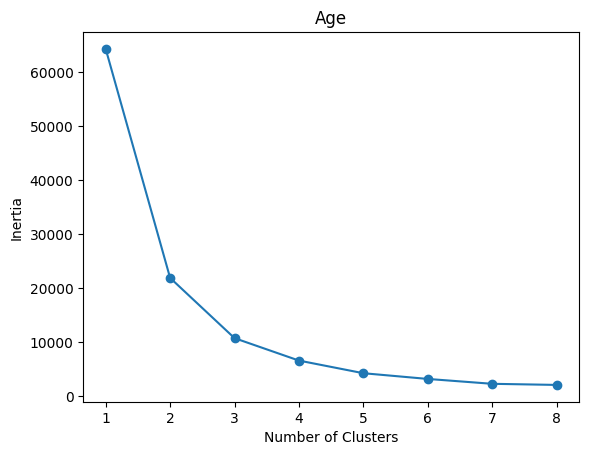

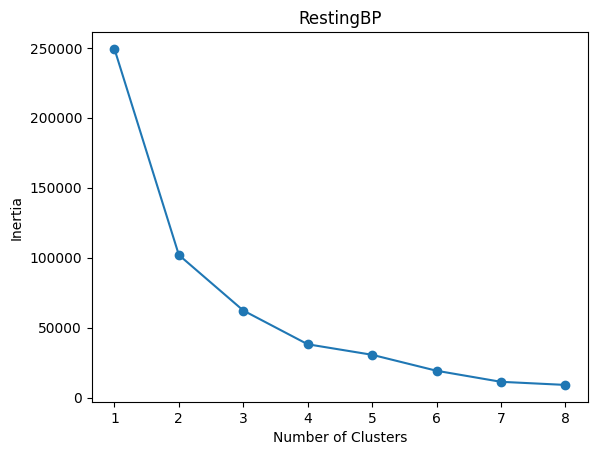

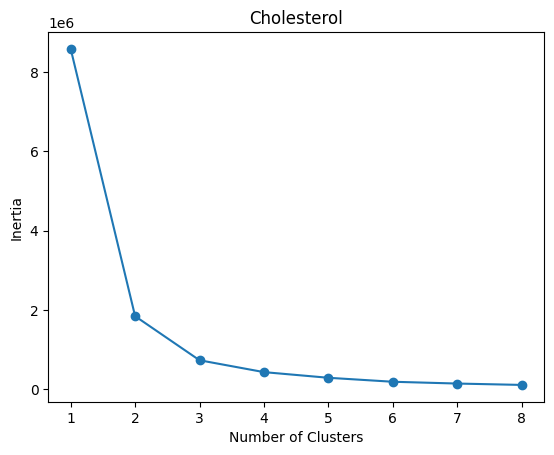

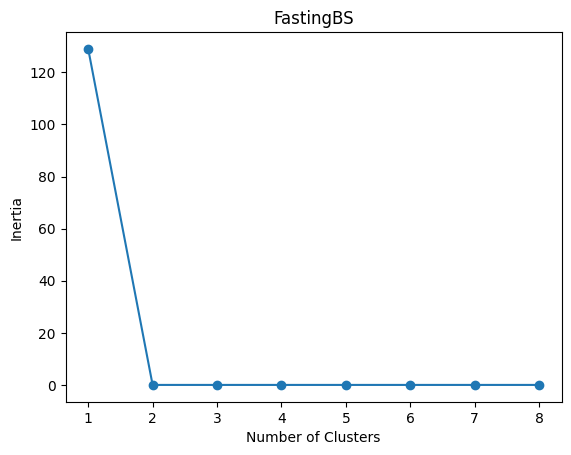

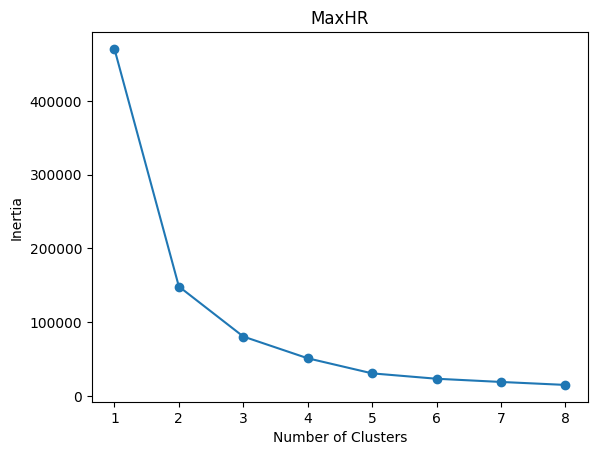

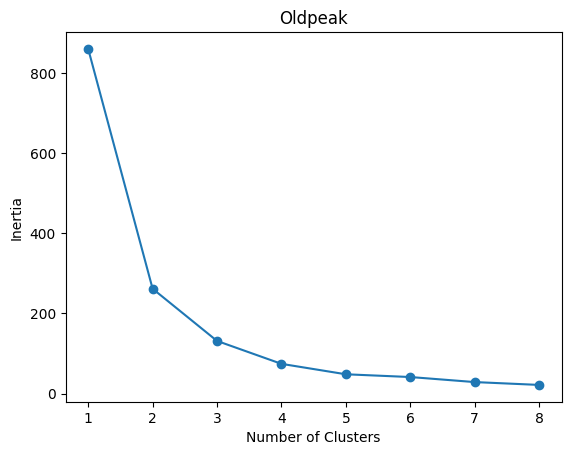

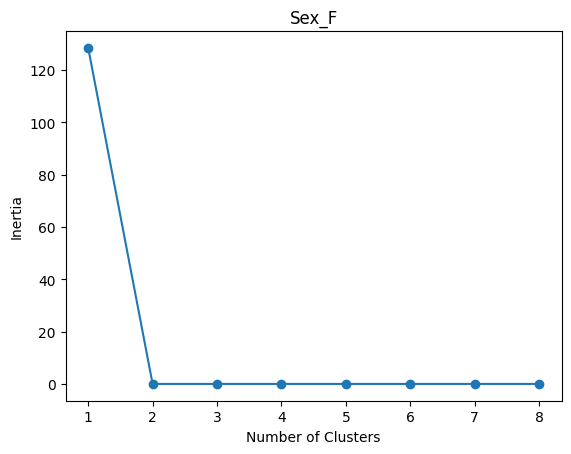

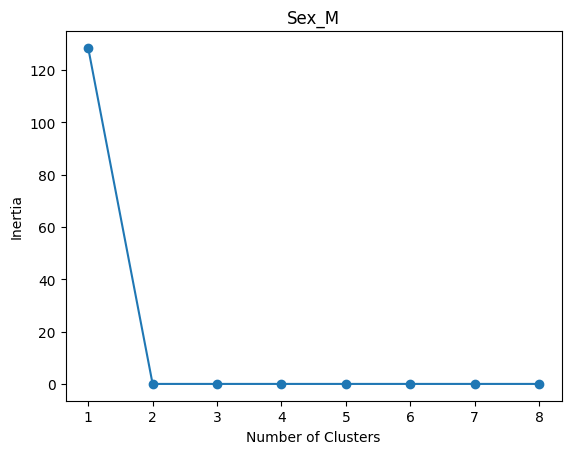

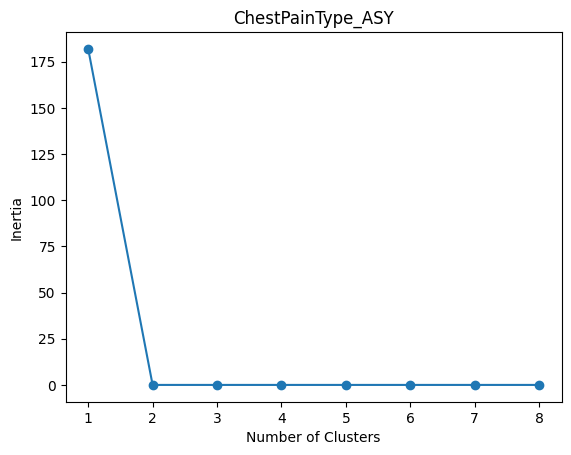

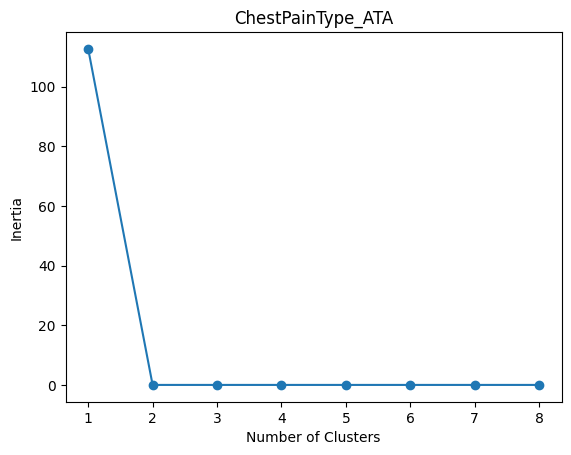

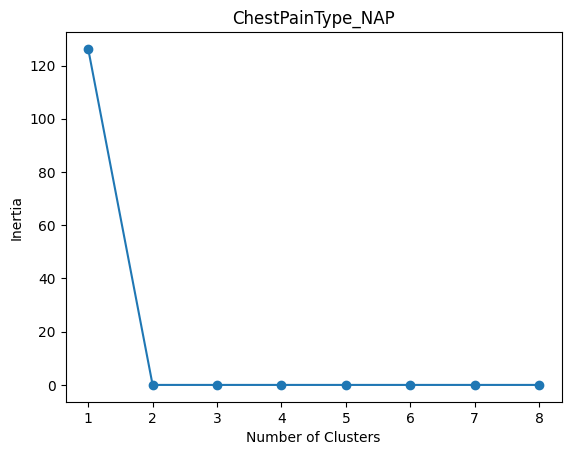

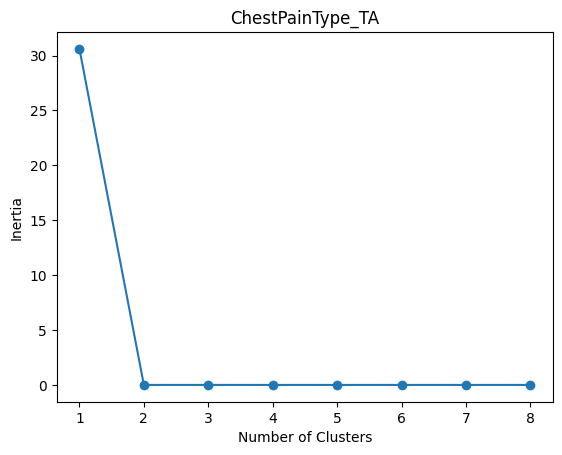

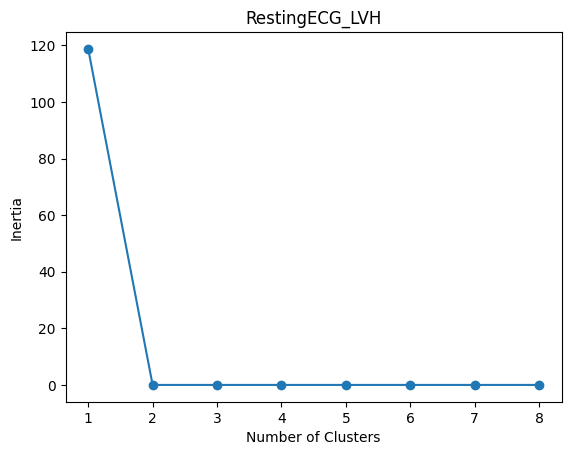

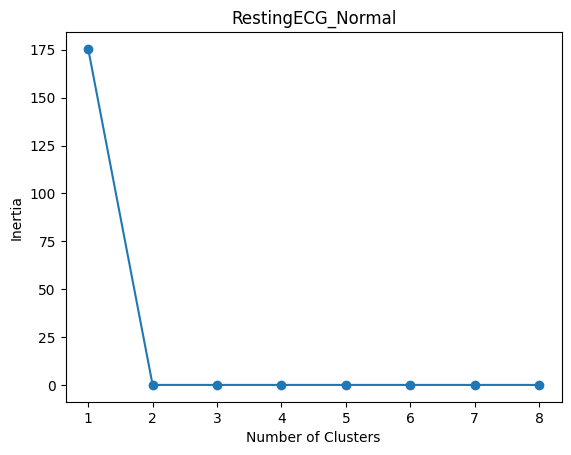

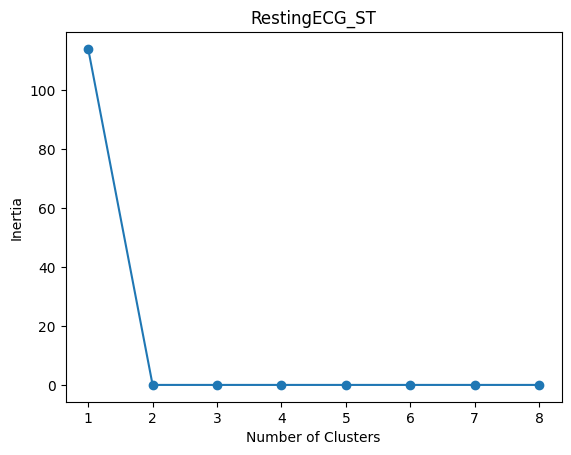

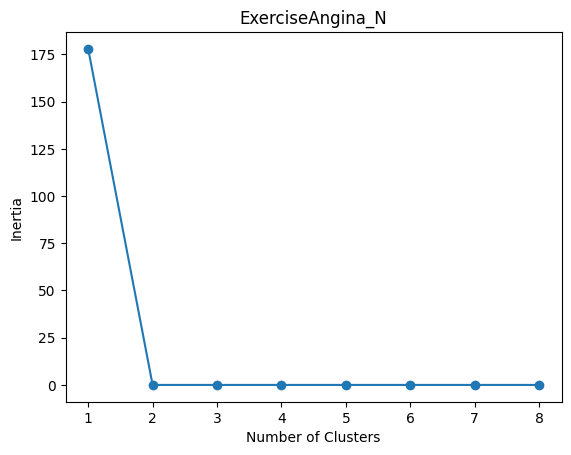

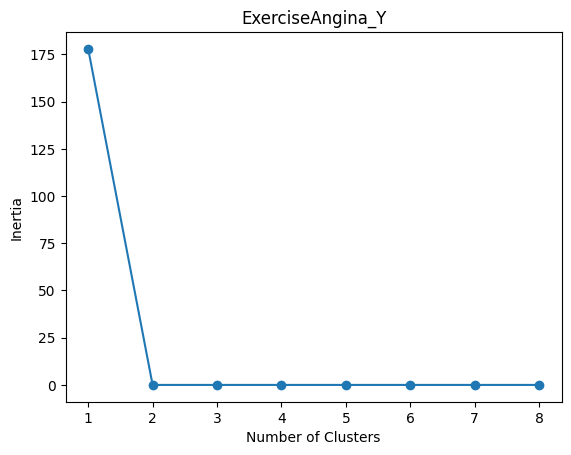

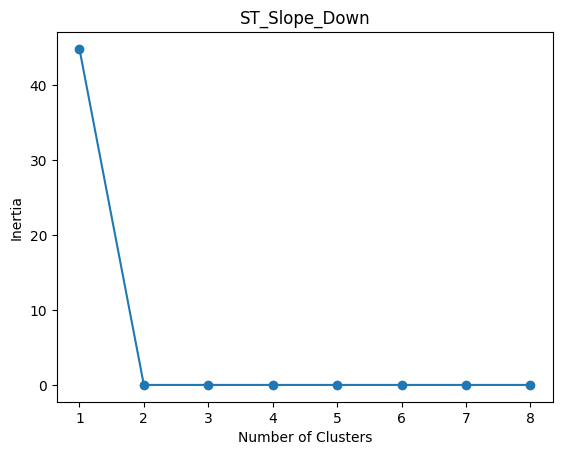

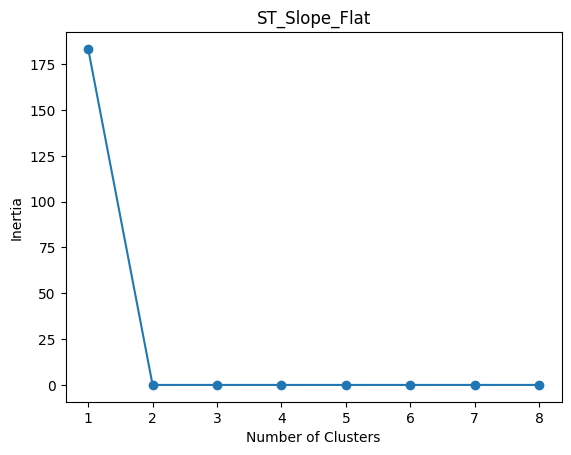

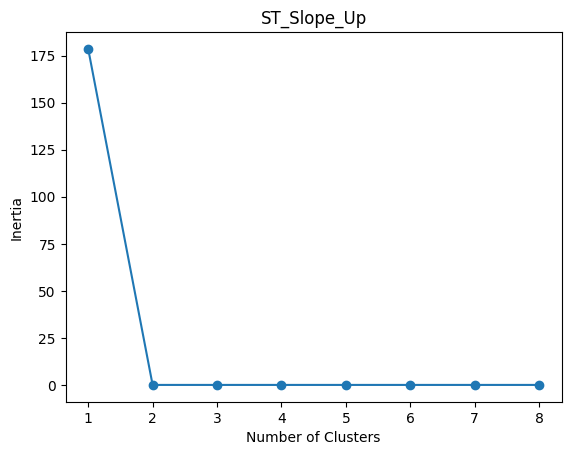

In [ ]:
for col in columns:
    column_data = X_train[col].values.reshape(-1, 1)
    warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")

    # Fit KMeans with a range of cluster numbers
    inertia_values = []
    possible_clusters = range(1, 9)

    for k in possible_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(column_data)
        inertia_values.append(kmeans.inertia_)

    # Elbow curve plot
    plt.plot(possible_clusters, inertia_values, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title(col)
    plt.show()

Inertia K=1: 8584080.670299724
Inertia K=2: 1842108.9584415657
Inertia K=3: 729931.5141545681
Inertia K=4: 430562.8373540452
Inertia K=5: 287982.5794878349
Inertia K=6: 187562.13216292483
Inertia K=7: 142377.70651826565
Inertia K=8: 107695.67296104923


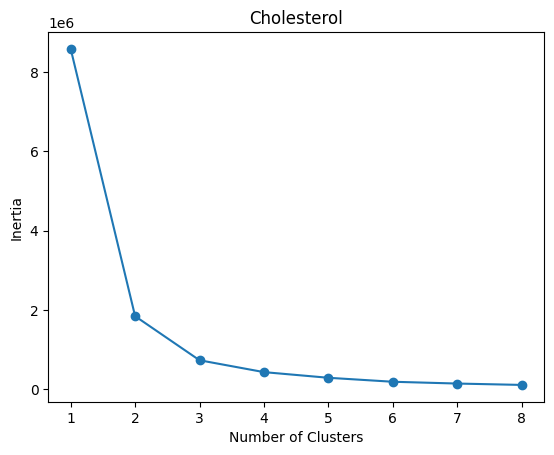

Number of clusters: 2
Silhouette score: 0.7914942270592769


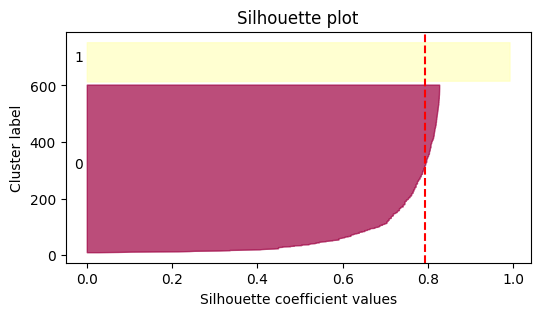

Number of clusters: 3
Silhouette score: 0.6546199343159316


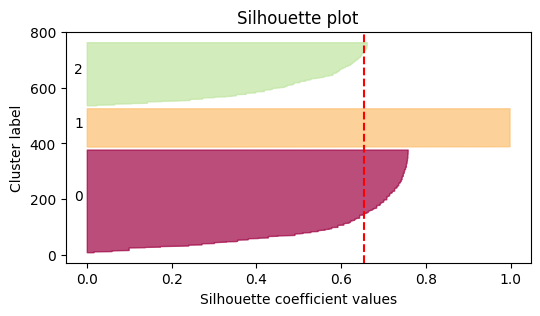

Number of clusters: 4
Silhouette score: 0.6441070157573415


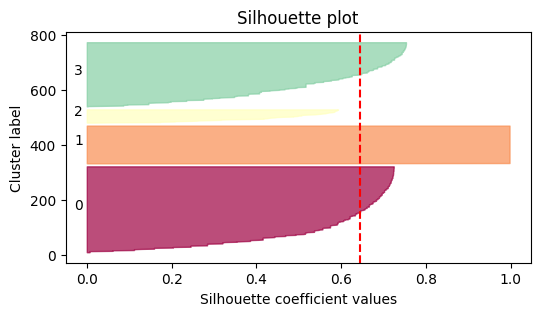

In [ ]:
column_data = X_train["Cholesterol"].values.reshape(-1, 1)

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
inertia_values = []
possible_clusters = range(1, 9)

for k in possible_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(column_data)
    inertia_values.append(kmeans.inertia_)

for k in possible_clusters:
    inertia = str(inertia_values[k-1])
    print("Inertia K=" + str(k) + ": " + inertia)

# Elbow curve plot
plt.plot(possible_clusters, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Cholesterol')
plt.show()

def plot_silhouette_analysis(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)

    # Silhouette scores
    silhouette_avg = silhouette_score(data, labels)
    sample_silhouette_values = silhouette_samples(data, labels)

    fig, ax1 = plt.subplots(1, 1, figsize=(6, 3))

    # Silhouette plot
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    print("Number of clusters: " + str(n_clusters))
    print("Silhouette score: " + str(silhouette_avg))
    plt.show()

for n_clusters in range(2, 5):
    plot_silhouette_analysis(column_data, n_clusters)

After running the "Elbow curve" method, it is observed that there are three strong candidates for the optimal $k$ value: 2, 3, and 4. Next, the "Silhouette score" method is executed using these three values mentioned above.

The results obtained are as follows:
  *   k=2: Inertia = 1842108, Silhouette Score = 0.79.
  *   k=3: Inertia = 729931, Silhouette Score = 0.65.
  *   k=4: Inertia = 430562, Silhouette Score = 0.64.

A comparison is made between k=2 and k=3, as well as between k=3 and k=4.
  *   Increasing the number of clusters from 2 to 3 results in a 60.38% reduction in Inertia, while the Silhouette score coefficient decreases by 17.72%.
  *   Increasing the number of clusters from 3 to 4 results in a 41.01% reduction in Inertia and a 1.54% decrease in the Silhouette score.

Considering the results from both methods, it can be observed that the Silhouette score when $k$ is 2 is significantly higher than when $k$ is 3 or 4. The high cohesion of points within the same cluster compensates for the higher Inertia value. Therefore, a cluster count of 2 is selected for the "Cholesterol" feature.

The same procedure is applied to the remaining features.

In [ ]:
unique_values_columns = X_train.nunique()
clusters_per_feature  = [3, 3, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
features_names = X_train.columns
clusters_per_feature_series = pd.Series(clusters_per_feature, index=features_names)
print(unique_values_columns)

Age                   47
RestingBP             60
Cholesterol          203
FastingBS              2
MaxHR                115
Oldpeak               49
Sex_F                  2
Sex_M                  2
ChestPainType_ASY      2
ChestPainType_ATA      2
ChestPainType_NAP      2
ChestPainType_TA       2
RestingECG_LVH         2
RestingECG_Normal      2
RestingECG_ST          2
ExerciseAngina_N       2
ExerciseAngina_Y       2
ST_Slope_Down          2
ST_Slope_Flat          2
ST_Slope_Up            2
dtype: int64


A function is defined to create a data transformer, where a KBinsDiscretizer is generated for each feature.

In [ ]:
def k_bins_discretizer(data, clusters_per_feature_series):
  transformers = []

  for column_name in columns:
    column = X_train[column_name]
    if ((column.dtype == 'float64') or (unique_values_columns[column_name] > 20)):
      transformer_name = 'discretize_' + column_name.replace('_', '')
      transformer = (transformer_name,
                      KBinsDiscretizer(n_bins=clusters_per_feature_series[column_name], encode='ordinal', strategy='kmeans'),
                      [column_name])
      transformers.append(transformer)

  discretizer = ColumnTransformer(
  transformers=transformers,
  remainder='passthrough',
  verbose_feature_names_out=False,
  ).set_output(transform="pandas")

  discretizer.fit(X_train)
  return discretizer

In [ ]:
discretizer = k_bins_discretizer(X_train, clusters_per_feature_series)

X_train_indexes = X_train.index
X_test_indexes = X_test.index

X_train = discretizer.transform(X_train)
X_test = discretizer.transform(X_test)

Normalization is applied to bring all values to the same scale, allowing for variance comparison.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train_indexes, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test_indexes, columns=X_test.columns)

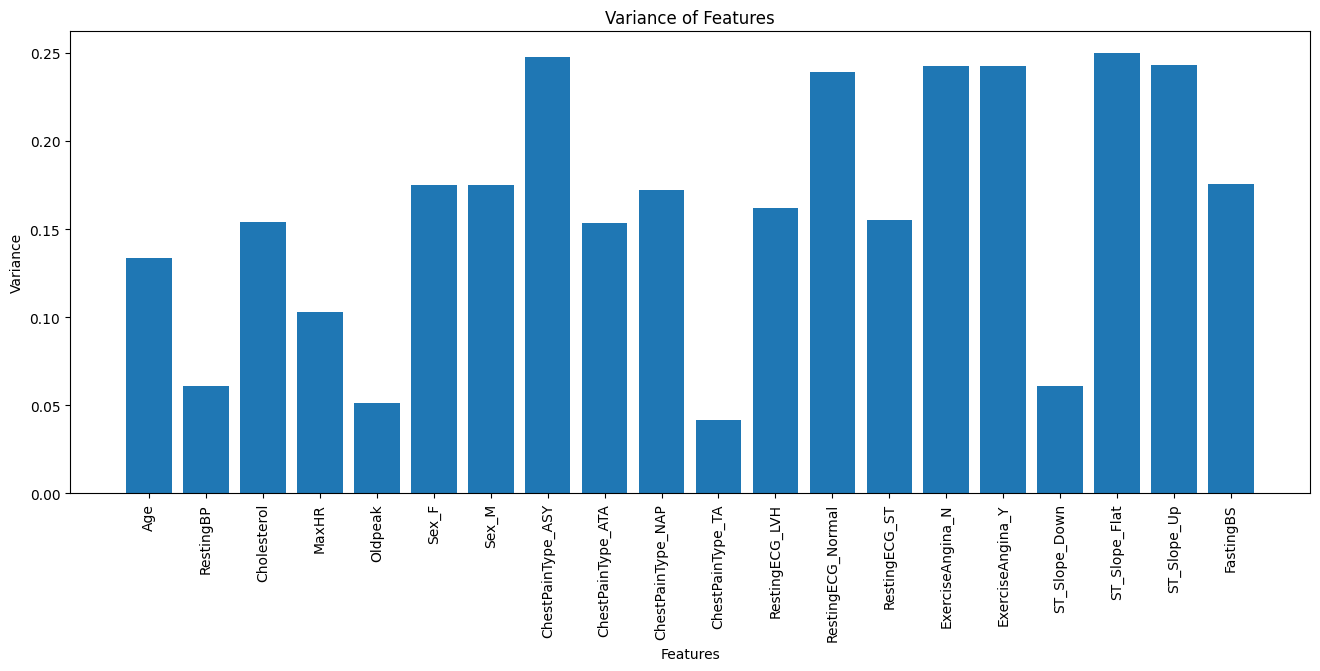

In [ ]:
# Variance calculation
variance_values = np.var(X_train, axis=0)

# Plot
plt.figure(figsize=(16, 6))
plt.bar(X_train.columns, variance_values)
plt.title('Variance of Features')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation='vertical')
plt.show()

A correlation matrix is constructed to study the linear relationships between the features and the target feature, as well as the linear relationships between the predictor features.

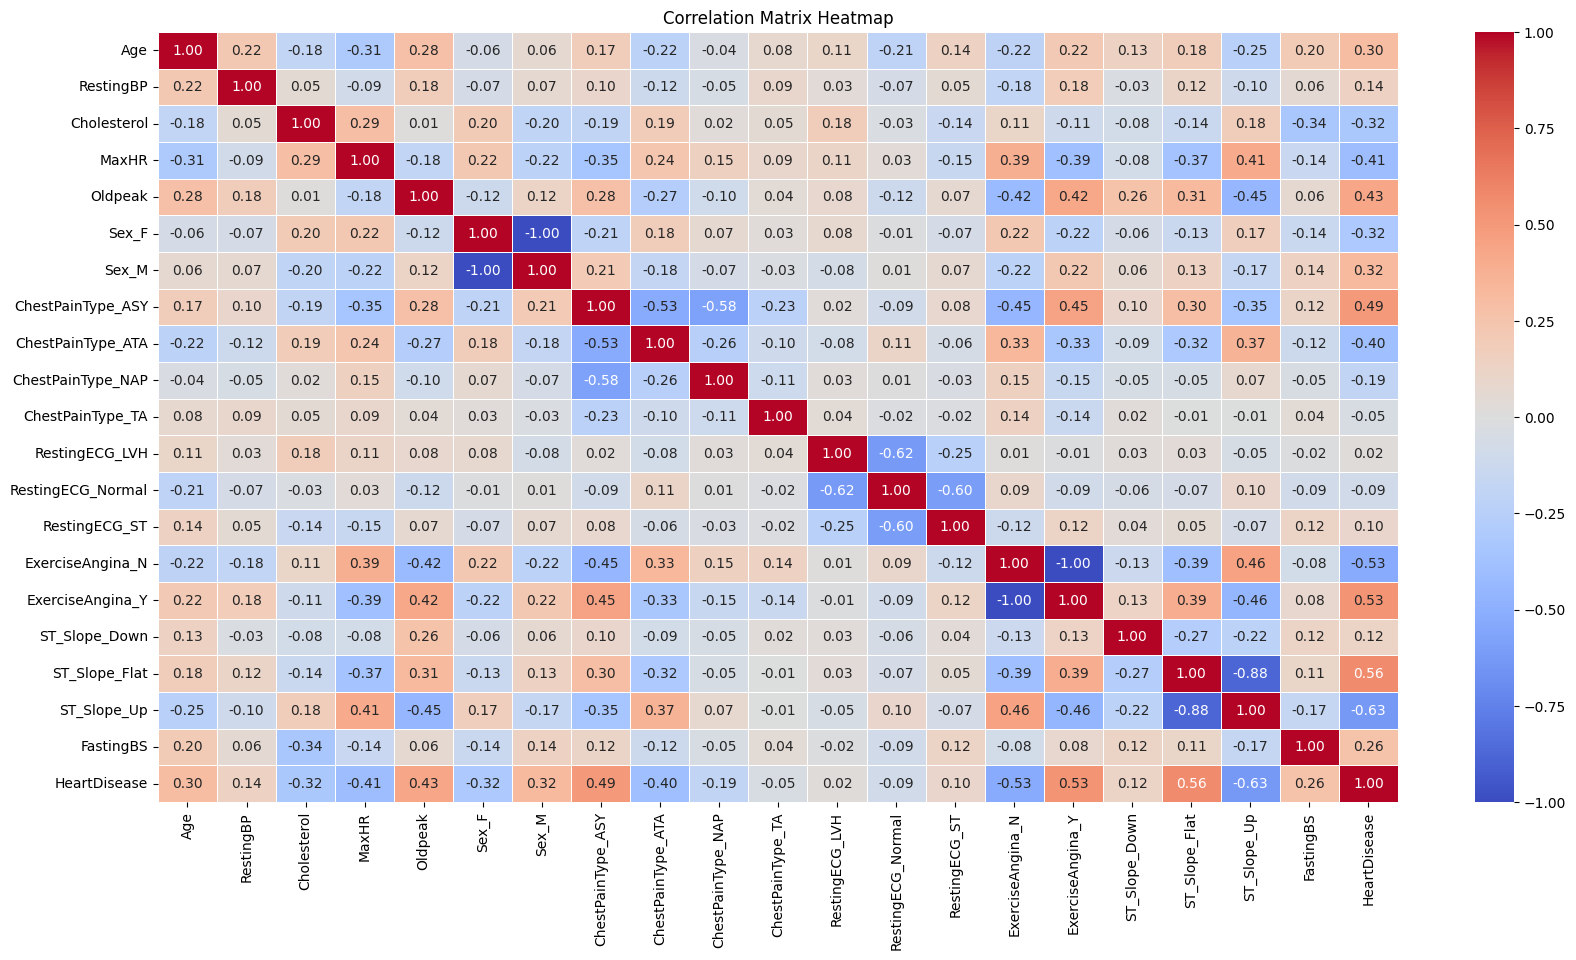

In [ ]:
X_train["HeartDisease"] = y_train
correlation_matrix = X_train.corr()

# Heatmap plot
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

Features with a low correlation coefficient (<0.20) relative to the target feature (HeartDisease) are removed.

In [ ]:
# Identify features to drop based on the threshold
features_to_drop = ["RestingBP", "ChestPainType_NAP", "ChestPainType_TA", "RestingECG_LVH", "RestingECG_Normal", "RestingECG_ST", "ST_Slope_Down"]

# Drop identified features
train_data = X_train.drop(columns=features_to_drop)
test_data = X_test.drop(columns=features_to_drop)
test_data["HeartDisease"] = y_test

train_data.head()

,Age,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,FastingBS,HeartDisease
795,0.0,1.0,1.000000,0.666667,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
25,0.0,1.0,1.000000,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
84,0.5,1.0,0.333333,0.666667,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1
10,0.0,1.0,0.666667,0.333333,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
344,0.5,0.0,0.000000,0.333333,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1


## Model Building, Training, and Testing:

The Laplace estimator is used to avoid issues associated with conditional probabilities equal to zero in the data. This issue arises when the training set has no entries where a feature takes the value $x$ and, simultaneously, the target feature takes the value $y$. In this case, $P(x|y)$ = 0. Using the Laplace estimator, we have:
$\text{P(x|y)} = \frac{n_x + \alpha}{N_y + \alpha K} $, where:

  *   $n_x$ is the number of times event $x$ occurs in the data,
  *   $\alpha$ is the Laplace smoothing parameter,
  *   $N_y$ represents the number of times the target feature takes the value $y$,
  *   $K$ is the number of features.

In [ ]:
element_counts = train_data["HeartDisease"].value_counts()
columns_modified = train_data.drop("HeartDisease", axis=1).columns
num_rows = train_data.shape[0]

alpha = 1
count_target_zero = element_counts[0]
count_target_one = element_counts[1]

conditional_probabilities = {}
conditional_probabilities_zero = {}
conditional_probabilities_one = {}
probability_target_zero = count_target_zero / num_rows
probability_target_one = count_target_one / num_rows

train_data_rows_size = train_data.shape[0]

for col in columns_modified:
  col_value_probability_zero = {}
  col_value_probability_one = {}
  unique_values_feature = train_data[col].unique().tolist()
  for value in unique_values_feature:
    count = len(train_data[(train_data[col] == value) & (train_data['HeartDisease'] == 0)])
    laplace = ((count + alpha) / (count_target_zero + alpha * len(unique_values_feature)))
    col_value_probability_zero[value] = laplace
    conditional_probabilities_zero[col] = col_value_probability_zero

  for value in unique_values_feature:
    count = len(train_data[(train_data[col] == value) & (train_data['HeartDisease'] == 1)])
    laplace = ((count + alpha) / (count_target_one + alpha * len(unique_values_feature)))
    col_value_probability_one[value] = laplace
    conditional_probabilities_one[col] = col_value_probability_one

column_names = list(conditional_probabilities_zero.keys())

print(column_names)

['Age', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up', 'FastingBS']


In [ ]:
X_train = train_data.iloc[:,:-1]
y_train = train_data[['HeartDisease']]

X_test = test_data.iloc[:,:-1]
y_test = test_data[['HeartDisease']]

y_pred = []
row_indices = X_test.index

for row in row_indices:
  accumulative_probability_zero = 1
  accumulative_probability_one = 1
  for col in X_test.columns:
    value = X_test.loc[row, col]

    conditional_prob_col_zero = conditional_probabilities_zero.get(col)
    col_val_probability_zero = conditional_prob_col_zero.get(value, "error")

    conditional_prob_col_one = conditional_probabilities_one.get(col)
    col_val_probability_one = conditional_prob_col_one.get(value, "error")

    if (col_val_probability_zero == "error"):
      accumulative_probability_zero *= ((1 + alpha) / (count_target_zero + alpha * len(columns_modified)))
    else:
      accumulative_probability_zero *= col_val_probability_zero

    if (col_val_probability_one == "error"):
      accumulative_probability_one *= ((1 + alpha) / (count_target_one + alpha * len(columns_modified)))
    else:
      accumulative_probability_one *= col_val_probability_one

  accumulative_probability_zero *= probability_target_zero
  accumulative_probability_one *= probability_target_one

  if accumulative_probability_zero > accumulative_probability_one:
    y_pred.append(0)
  else:
    y_pred.append(1)


The model's performance is evaluated on the test set (X_test).

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
metrics_info = metrics.classification_report(y_test, y_pred)

print(accuracy)
print(metrics_info)

0.8586956521739131
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        77
           1       0.91      0.84      0.87       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



Now, performance is evaluated using MultinomialNB() from sklearn.naive_bayes.

In [ ]:
# Clasificador Naive Bayes Multinomial
model = MultinomialNB()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
metrics_info = metrics.classification_report(y_test, predictions)

print(accuracy)
print(metrics_info)
print("Accuracy:", accuracy)

0.8369565217391305
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        77
           1       0.88      0.83      0.86       107

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.84      0.84       184

Accuracy: 0.8369565217391305
